
## Model variance

#### Xuesong Ma
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin


_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

This project aims to explain and demonstrate the model variance in the context of polynomial regression with bootstrap of the training dataset. Model variance refers to the varaibility of the model's predicitions when applied to different datasets. By applying the bootstrap method, we explore how different training data subsets affect the performance of polynomial regression models. The bootstrap technique is a statistical method used to estimate the variability of a model by repeatedly sampling with replacement from the original dataset. It allows us to simulate different training sets and observe the resulting model predictions, providing insights into model variance. I recommend to use lower-degree polynomials for more stable models with reduced variance.


### Import Packages



In [2]:
import numpy as np   # for working with data and model arrays
import matplotlib.pyplot as plt  # for visualization
from sklearn.preprocessing import PolynomialFeatures # for polynomial regression
from sklearn.linear_model import LinearRegression # for polynomial regression
from sklearn.pipeline import make_pipeline # for connection between steps in polynomial regression
from sklearn.utils import resample  # bootstrap resample
from sklearn.preprocessing import QuantileTransformer # for Gaussian transform

This workflow uses some polynomial basis expansion codes from Applied Machine Learning in Python: a Hands-on Guide with Code. The refered workflow can be viewed here: [Polynomial Regression](https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_polynomial_regression.html)


### Functions

The following functions will be used in the workflow. The polynomial_regression function receives the training data and polynomial degree and returns the polynomial model to get model parameters and to make predictions. Another function named bootstrap_model_variance receives the training data, polynomial degree, and number of bootstraps. This function returns the variance of model parameters and predictions.

In [3]:
# Function to fit a piecewise linear model
def polynomial_regression(X, y, degree=3):
    # Create polynomial features for the data
    poly = PolynomialFeatures(degree=degree)  # instantiate polynomial expansion
    X_poly = poly.fit_transform(X)            # calculate the basis expansion
    model = LinearRegression()                # instantiate new linear model
    model.fit(X_poly, y)                      # train linear model with polynomial expansion
    return model, poly

# Bootstrap method to evaluate variance
def bootstrap_model_variance(X, y, B=1000, degree=3):
    n = len(X)
    coefs = []
    intercepts = []
    predictions = np.zeros((B, n))

    # Perform B bootstrap resampling
    for b in range(B):
        # Bootstrap resample the data
        X_b, y_b = resample(X, y, n_samples=n)

        model, poly = polynomial_regression(X_b, y_b, degree)

        # Store the coefficients and intercept
        coefs.append(model.coef_)
        intercepts.append(model.intercept_)

        # Transform the original data and make predictions
        X_poly = poly.transform(X)  # Transform the original data to polynomial features
        predictions[b, :] = model.predict(X_poly)


    coefs = np.array(coefs)
    intercepts = np.array(intercepts)

    # Calculate the variance of the coefficients
    coef_variance = np.var(coefs, axis=0)
    intercept_variance = np.var(intercepts, axis=0)

    # Calculate the variance of the predictions for each point
    pred_variance = np.var(predictions, axis=0)

    return coefs, intercepts, predictions, coef_variance, intercept_variance, pred_variance

### Data Generation

We will work on a nonlinear synthetic dataset comprised of sin and cos functions.
* Create nonlinear dataset
* Visualize the data by scatter plot

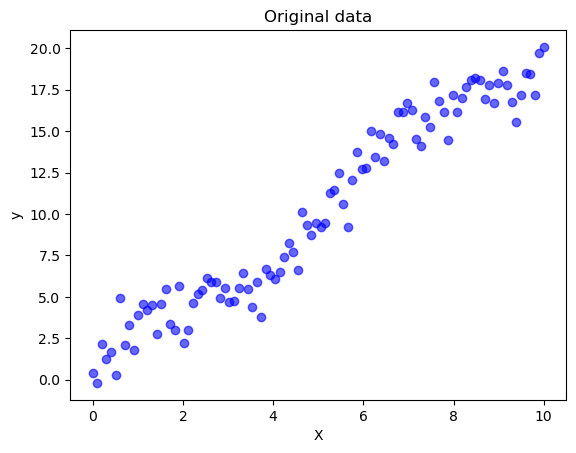

In [6]:
# Training Data
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2*X.flatten() + np.sin(X).ravel() + np.cos(X).ravel() + np.random.normal(0, 1, 100)
plt.subplot(111)
plt.scatter(X, y, color='blue', label='Original Data', alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
# plt.xlim([-.5,10.5])
# plt.ylim([-.5,20.5])
plt.title('Original data')
plt.show()

### Gaussian Transform
* Transform the data to standard normal in Gaussian distribution with a mean of 0.0 and standard deviation of 1.0
* Make cumulative distribution function plots to check the original and transformed variables.

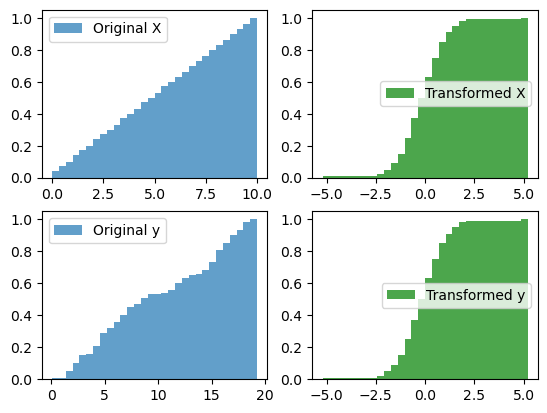

In [12]:
nscore = QuantileTransformer(n_quantiles=100, random_state=73, output_distribution='normal')
data_X = nscore.fit_transform(X.reshape(-1,1))
data_y = nscore.fit_transform(y.reshape(-1,1))

# Visualizing the transformed data
plt.subplot(221)
plt.hist(X, bins=30, alpha=0.7, cumulative=True, histtype='stepfilled', density=True, label='Original X')
plt.legend()
plt.subplot(222)
plt.hist(data_X, bins=30, alpha=0.7, color='green', cumulative=True, histtype='stepfilled', density=True, label='Transformed X')
plt.legend()
plt.subplot(223)
plt.hist(y, bins=30, alpha=0.7, cumulative=True, histtype='stepfilled', density=True, label='Original y')
plt.legend()
plt.subplot(224)
plt.hist(data_y, bins=30, alpha=0.7, color='green', cumulative=True, histtype='stepfilled', density=True, label='Transformed y')
plt.legend()
plt.show()

### Workflow Oveview


1. Bootstrap the model variance using a low polynomial degree of 3

2. Visulize the prediction data and the bootstrapped prediction variance

3. Bootstrap the model variance using a high polynomial degree of 6

4. Visulize the prediction data and the bootstrapped prediction variance

5. Bootstrap the model variance with degrees 1 to 6 and compare the variance in the main coefficient (slope of x)

### 1. Bootstrap the model variance using a low polynomial degree of 3

* Use a low degree of polynomial expansion and fit the linear regression model to the polynomial basis expansion. 
* Use bootstrap to resample the original data for 1000 times
* Calculate the coefficientes and intercept and make model predictions based on each resample data
* Calculate the variance of coefficients and intercept


In [8]:
coefs, intercepts, predictions3, coef_variance3, intercept_variance3, pred_variance = bootstrap_model_variance(X, y, B=1000, degree=3)


### 2. Visulize the prediction data and the bootstrapped prediction variance

Create a plot to visualize the original data and the model predictions, as well as bootstrapped prediction variance (±5 std).

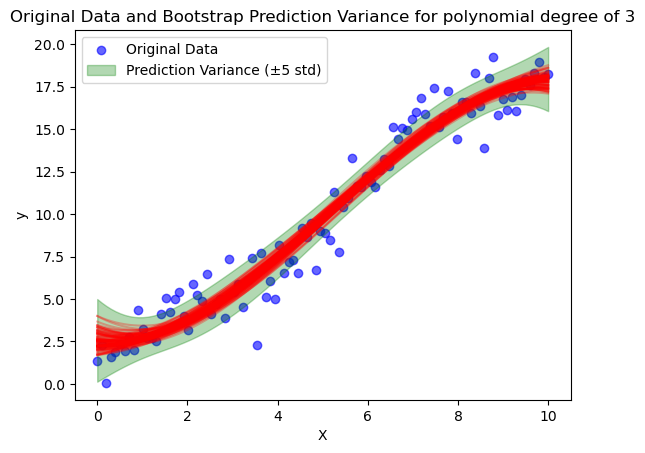

In [48]:
plt.subplot(111)
plt.scatter(X, y, color='blue', label='Original Data', alpha=0.6)
for b in range(100):  # Loop over each bootstrap sample
    plt.plot(X, predictions3[b, :], color='red', alpha=0.3)  # Each bootstrap prediction as a thin line
# plt.plot(X, np.mean(predictions, axis=0), color='red', label='Mean Prediction', linewidth=2)
plt.fill_between(X.ravel(), np.mean(predictions3, axis=0) - 5*np.std(predictions3, axis=0),
                 np.mean(predictions3, axis=0) + 5*np.std(predictions3, axis=0),
                 color='green', alpha=0.3, label='Prediction Variance (±5 std)')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Original Data and Bootstrap Prediction Variance for polynomial degree of 3')
plt.legend()
plt.show()

### 3. Bootstrap the model variance using a low polynomial degree of 6

* Use a high degree of polynomial expansion and fit the linear regression model to the polynomial basis expansion. 
* Use bootstrap to resample the original data for 1000 times
* Calculate the coefficientes and intercept and make model predictions based on each resample data
* Calculate the variance of coefficients and intercept

In [10]:
coefs, intercepts, predictions, coef_variance, intercept_variance, pred_variance = bootstrap_model_variance(X, y, B=1000, degree=6)


### 4. Visulize the prediction data and the bootstrapped prediction variance

Create a plot to visualize the original data and the model predictions, as well as bootstrapped prediction variance (±5 std).

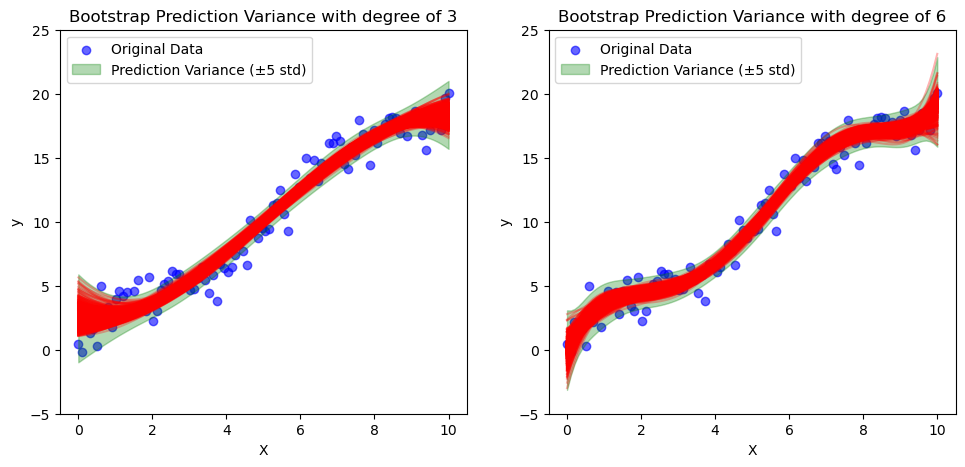

In [12]:
plt.subplot(121)
plt.scatter(X, y, color='blue', label='Original Data', alpha=0.6)
for b in range(1000):  # Loop over each bootstrap sample
    plt.plot(X, predictions3[b, :], color='red', alpha=0.3)  # Each bootstrap prediction as a thin line
# plt.plot(X, np.mean(predictions, axis=0), color='red', label='Mean Prediction', linewidth=2)
plt.fill_between(X.ravel(), np.mean(predictions3, axis=0) - 5*np.std(predictions3, axis=0),
                 np.mean(predictions3, axis=0) + 5*np.std(predictions3, axis=0),
                 color='green', alpha=0.3, label='Prediction Variance (±5 std)')
plt.xlabel('X')
plt.ylabel('y')
plt.ylim([-5,25])
plt.title('Bootstrap Prediction Variance with degree of 3')
plt.legend()




plt.subplot(122)
plt.scatter(X, y, color='blue', label='Original Data', alpha=0.6)
for b in range(1000):  # Loop over each bootstrap sample
    plt.plot(X, predictions[b, :], color='red', alpha=0.3)  # Each bootstrap prediction as a thin line
# plt.plot(X, np.mean(predictions, axis=0), color='red', label='Mean Prediction', linewidth=2)
plt.fill_between(X.ravel(), np.mean(predictions, axis=0) - 5*np.std(predictions, axis=0),
                 np.mean(predictions, axis=0) + 5*np.std(predictions, axis=0),
                 color='green', alpha=0.3, label='Prediction Variance (±5 std)')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Bootstrap Prediction Variance with degree of 6')
plt.legend()
plt.ylim([-5,25])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.4, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

Plot the variance of coefficients, intercept between two degrees of polynomial regression

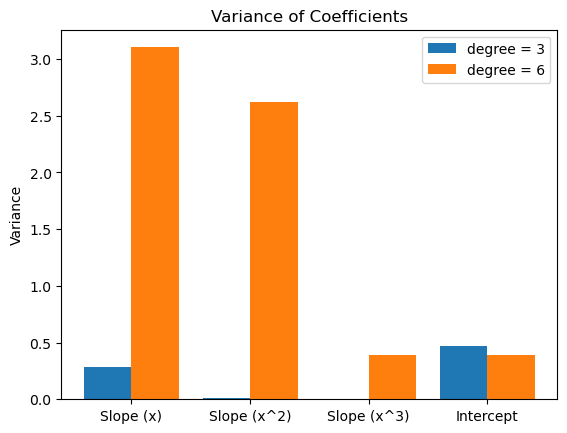

In [14]:
plt.subplot(111)
cats = ['Slope (x)', 'Slope (x^2)', 'Slope (x^3)', 'Intercept']
w, x = 0.4, np.arange(len(cats))
plt.bar(x - w/2, [coef_variance3[1], coef_variance3[2], coef_variance3[3], intercept_variance3], width=w, label='degree = 3')
plt.bar(x + w/2, [coef_variance[1], coef_variance[2], coef_variance[3], intercept_variance], width=w, label='degree = 6')
plt.ylabel('Variance')
plt.xticks(x, cats)
plt.title('Variance of Coefficients')
plt.legend()
plt.show()

### 5. Bootstrap the model variance with degrees 1 to 6 and compare the variance in the main coefficient (slope of x)

In [16]:
var_slope = []
for i in range(1,7):
    _, _, _, coef_variance, _, _ = bootstrap_model_variance(X, y, B=1000, degree=i)
    var_slope.append(coef_variance[1])


Create a line plot for the variances in the main coeffiecient, that is, the slope of x among degrees 1 to 6.

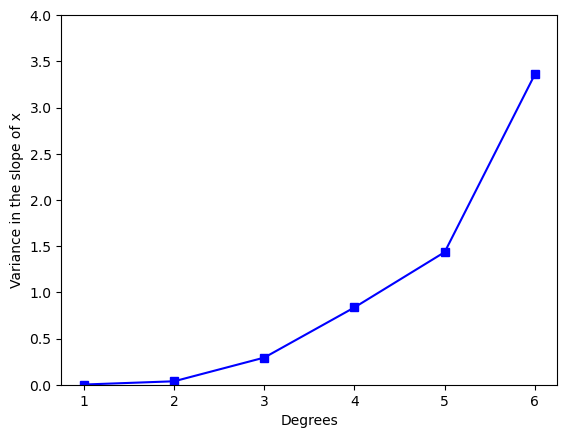

[0.0020881104965776616, 0.03720987944280077, 0.29378487919248536, 0.8368915243520629, 1.4351584431170108, 3.3585629312003893]


In [22]:
plt.plot(np.arange(1,7), var_slope, 'bs-')
plt.xlabel('Degrees')
plt.ylabel('Variance in the slope of x')
plt.ylim([0,4])
plt.show()


### Results
By applying the bootstrap method to polynomial regression models of varying degrees, we observe how model variance increases as the degree of the polynomial increases. The sensitity to the specific data points in the training set can cause high variance, where small changes in the data lead to significantly different model predictions.

Specifically, low-degree polynomial models tend to have lower variance in model coefficients, as they are less sensitive to fluctuations in the training data, compared with high-degree models. High-degree models exhibit higher variance. The predictions for different bootstrap samples vary significantly, illustrating the instability of such models. From the distribution of model predictions across bootstrap samples, we can visualize the spread and varibality. Wider distributions indicate higher variance. Higher-degree polynomials allow for more flexibility in capturing complex patterns, but they are more prone to overfitting.


Polynomial regression, especially with higher-degree polynomials, is prone to high variance and potential overfitting, a phenomenon that can be clearly demonstrated through bootstrap simulations. As model complexity increases, care should be taken to balance the trade-off between model flexibility and stability.

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)